In [351]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [352]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Metricas de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VN = churm[0,0]
    FP = churm[0,1]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Metricas de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VN = churm[1,1]
    FP = churm[1,0]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [353]:
def matriz_confusion(validacion, prediccion, cmap):
    print(colored('Matriz de confusión', attrs=['bold']))
    churm = metrics.confusion_matrix(validacion, prediccion)
    plt.imshow(churm, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not_mine','Mine'])
    plt.yticks(tick_marks, ['Not_mine','Mine'])
    return churm

# Importar datos Puros

In [354]:
dataA = pd.read_csv('./data_identificada.csv').drop(['Second_Protocol', 'Third_Protocol','Cryptocurrency'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,82,TCP,2.9595,103.6315,135.19425,6709.539,184.327,0.0,407,1266,...,443,5355.0,80.0,3.0,5.0,5.75,84.0,160.0,248.0,not_mine


# Preprocesamiento

### Imputación de valores ausentes

In [355]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [356]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

In [357]:
dataCopyA = dataA
dataA.shape

(4733, 28)

In [358]:
print(colored('Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo', attrs=['bold']))
porcion_no_minera_conjuntoA = dataCopyA[dataCopyA.Type == "not_mine"]
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.sample(n=750)

Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo


In [359]:
porcion_no_minera_conjuntoA.shape

(750, 28)

In [360]:
dataA.shape

(4733, 28)

In [361]:
dataA = dataA[~dataA.index.isin(porcion_no_minera_conjuntoA.index)]

Balance del conjunto de datos


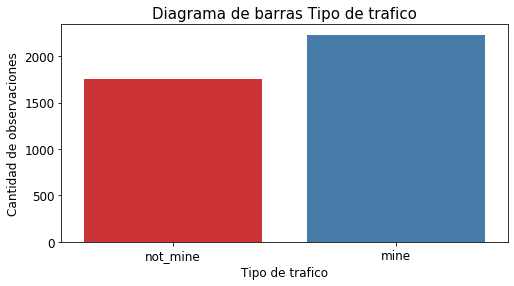

In [362]:
print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type', data=dataA, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

### OneHotEncoder

In [363]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<3983x6 sparse matrix of type '<class 'numpy.float64'>'
	with 7966 stored elements in Compressed Sparse Row format>

In [364]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine
2,0,0,1,0,0,1
3,0,0,1,0,1,0


In [365]:
dataA = dataA.drop(['First_Protocol','Type'],axis = 1)

In [366]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'Type_not_mine'],
      dtype='object')

# Árbol de decisión

In [367]:
y = dataA['Type_mine']
X = dataA.drop(['Type_mine','Type_not_mine'],axis = 1)

### Holdout

In [368]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [369]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [370]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 2
Número de nodos terminales: 3


[Text(223.2, 453.0, 'first_sp <= 1887.5\nsamples = 2788\nvalue = [1221, 1567]\nclass = i'),
 Text(111.6, 271.8, 'samples = 1201\nvalue = [1201, 0]\nclass = T'),
 Text(334.79999999999995, 271.8, 'First_Protocol_TCP <= 0.5\nsamples = 1587\nvalue = [20, 1567]\nclass = i'),
 Text(223.2, 90.59999999999997, 'samples = 20\nvalue = [20, 0]\nclass = T'),
 Text(446.4, 90.59999999999997, 'samples = 1567\nvalue = [0, 1567]\nclass = i')]

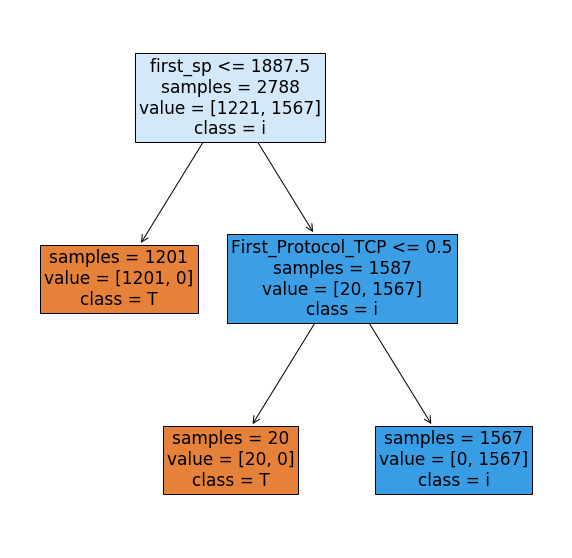

In [371]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [372]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([0, 1, 1, ..., 1, 1, 0], dtype=uint8)

In [373]:
len(y_pred[y_pred == 0])

530

In [374]:
len(y_pred[y_pred == 1])

665

### Métricas y matriz de confusión

Matriz de confusión


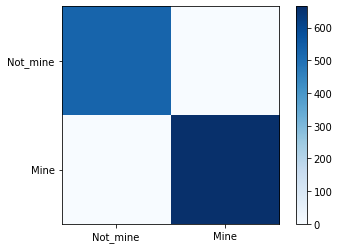

In [375]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [376]:
pd.DataFrame(churm)

,0,1
0,530,0
1,0,665


In [377]:
print("El modelo arbol de dicición se equivocó en %d de los %d registros que componen el dataset de mineria no pura"
      % ((y_test != y_pred).sum(), dataA.shape[0]))

El modelo arbol de dicición se equivocó en 0 de los 3983 registros que componen el dataset de mineria no pura


In [378]:
metricas(y_test, y_pred, churm)

Exactitud:  1.0
Kappa:  1.0
Metricas de los registros mineros
Precisión:  1.0
Recall:  1.0
Especificidad :  1.0
F1-score      :  1.0
Metricas de los registros no mineros
Precisión:  1.0
Recall:  1.0
Especificidad :  1.0
F1-score      :  1.0


# Experimento 1

In [379]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv').drop(['Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Importo el conjunto de datos no puros


Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [380]:
dataB = pd.concat([dataB[dataB.Type == 'mine'],porcion_no_minera_conjuntoA], axis = 0)

### Imputar valores

In [381]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [382]:
punter = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = punter['second_sp']
dataB['second_dp'] = punter['second_dp']
dataB['third_sp'] = punter['third_sp']
dataB['third_dp'] = punter['third_dp']

### OneHotEncoder

In [383]:
data_categoric = dataB[dataB.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<37803x6 sparse matrix of type '<class 'numpy.float64'>'
	with 75606 stored elements in Compressed Sparse Row format>

In [384]:
data_dummy = pd.get_dummies(data_categoric).drop('Type_not_mine',axis=1)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine
0,0,0,1,0,1
1,0,0,1,0,1


In [385]:
dataB = pd.concat([dataB,data_dummy], axis = 1).drop(['First_Protocol','Type'],axis=1)
dataB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [386]:
X_train.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP'],
      dtype='object')

In [387]:
X = dataB.drop(['Type_mine'],axis=1)
y = dataB['Type_mine']

### Realizo la predicción

In [388]:
y_pred = model.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Matriz de confusión


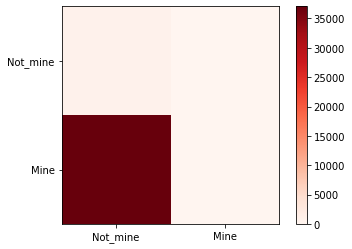

In [389]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [390]:
pd.DataFrame(churm)

,0,1
0,750,0
1,37052,1


In [391]:
print("El modelo de en el experimento 1 se equivocó en %d de los %d registros que componen el dataset de mineria no pura"
      % ((y != y_pred).sum(), dataB.shape[0]))

El modelo de en el experimento 1 se equivocó en 37052 de los 37803 registros que componen el dataset de mineria no pura


In [392]:
metricas(y, y_pred, churm)

Exactitud:  0.019866148189297144
Kappa:  1.0709097493233344e-06
Metricas de los registros mineros
Precisión:  1.0
Recall:  2.698836801338623e-05
Especificidad :  1.0
F1-score      :  5.3975279322070496e-05
Metricas de los registros no mineros
Precisión:  0.019840220094174913
Recall:  1.0
Especificidad :  2.698836801338623e-05
F1-score      :  0.03890848723801619


# Experimento 2

In [393]:
print(colored('Caracteristicas del conjunto de datos de mineria pura', attrs=['bold']))
best_feature_sel = ['#dp', '#sp', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_ib', 'p3_d', 'p3_ib', 'second_dp', 'second_sp']
print(best_feature_sel)

Caracteristicas del conjunto de datos de mineria pura
['#dp', '#sp', 'First_Protocol_ICMP6', 'First_Protocol_TCP', 'First_Protocol_UDP', 'first_dp', 'first_sp', 'min_d', 'p1_d', 'p1_ip', 'p2_ib', 'p3_d', 'p3_ib', 'second_dp', 'second_sp']


# II Árbol de decisión

In [394]:
y = dataA['Type_mine']
X = dataA[best_feature_sel]

# Hodount

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

# Modelo

In [396]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model_II = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [397]:
print(colored('Entreno el modelo', attrs=['bold']))
model_II.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 2
Número de nodos terminales: 3


[Text(223.2, 453.0, 'first_sp <= 1887.5\nsamples = 2788\nvalue = [1212, 1576]\nclass = i'),
 Text(111.6, 271.8, 'samples = 1195\nvalue = [1195, 0]\nclass = T'),
 Text(334.79999999999995, 271.8, 'First_Protocol_UDP <= 0.5\nsamples = 1593\nvalue = [17, 1576]\nclass = i'),
 Text(223.2, 90.59999999999997, 'samples = 1576\nvalue = [0, 1576]\nclass = i'),
 Text(446.4, 90.59999999999997, 'samples = 17\nvalue = [17, 0]\nclass = T')]

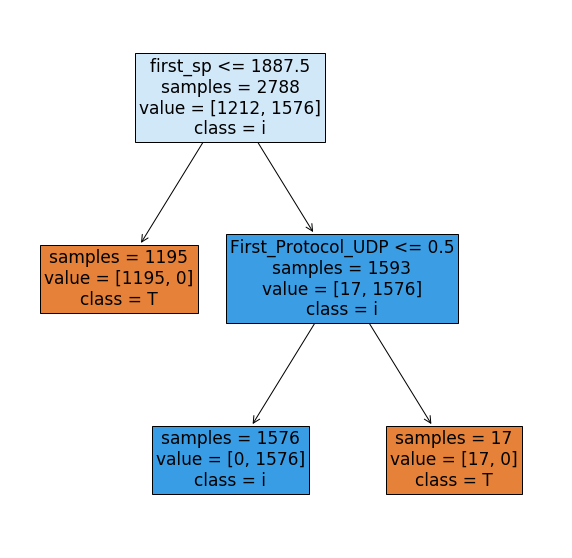

In [398]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model_II.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model_II.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model_II,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [399]:
X = dataB[best_feature_sel]
y = dataB['Type_mine']

In [400]:
y_pred = model_II.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Matriz de confusión


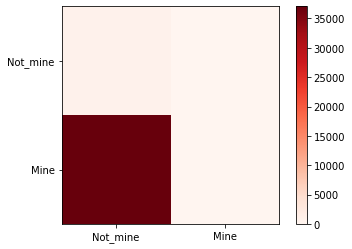

In [401]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [402]:
metricas(y, y_pred, churm)

Exactitud:  0.019866148189297144
Kappa:  1.0709097493233344e-06
Metricas de los registros mineros
Precisión:  1.0
Recall:  2.698836801338623e-05
Especificidad :  1.0
F1-score      :  5.3975279322070496e-05
Metricas de los registros no mineros
Precisión:  0.019840220094174913
Recall:  1.0
Especificidad :  2.698836801338623e-05
F1-score      :  0.03890848723801619


# Experimento 3

In [403]:
print(colored('Caracteristicas del conjunto de datos puro', attrs=['bold']))
print(best_feature_sel)

Caracteristicas del conjunto de datos puro
['#dp', '#sp', 'First_Protocol_ICMP6', 'First_Protocol_TCP', 'First_Protocol_UDP', 'first_dp', 'first_sp', 'min_d', 'p1_d', 'p1_ip', 'p2_ib', 'p3_d', 'p3_ib', 'second_dp', 'second_sp']


In [404]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['First_Protocol_ICMP6', 'First_Protocol_TCP', 'First_Protocol_UDP',
       'first_dp', 'first_sp', 'min_d', 'p1_ib', 'second_dp','Type_mine']
print(best_feature_noPure)

Caracteristicas del conjunto de datos no puro
['First_Protocol_ICMP6', 'First_Protocol_TCP', 'First_Protocol_UDP', 'first_dp', 'first_sp', 'min_d', 'p1_ib', 'second_dp', 'Type_mine']


In [405]:
print(colored('Combino las caracteristicas', attrs=['bold']))
bestFeature = np.concatenate([best_feature_sel,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

Combino las caracteristicas


array(['#dp', '#sp', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'first_dp', 'first_sp', 'min_d',
       'p1_d', 'p1_ib', 'p1_ip', 'p2_ib', 'p3_d', 'p3_ib', 'second_dp',
       'second_sp'], dtype='<U20')

In [406]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
porcion_minera_conjuntoB = dataB[dataB.Type_mine == 1]
porcion_minera_conjuntoB = porcion_minera_conjuntoB.sample(n=dataCopyA[dataCopyA.Type == "mine"].shape[0])

Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos


In [407]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros


In [408]:
copy_porcion_minera_conjuntoB = porcion_minera_conjuntoB 

In [409]:
data_final = pd.concat([dataA[bestFeature], porcion_minera_conjuntoB[bestFeature], ], axis = 0)
data_final.shape

(6215, 17)

Balance del conjunto de datos


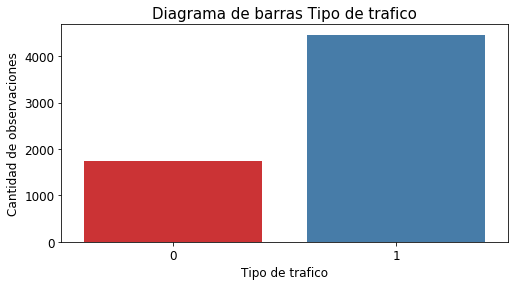

In [410]:
print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type_mine', data=data_final, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

In [411]:
sobre_muestreo_no_minera = data_final[data_final.Type_mine == 0]
data_final = pd.concat([data_final, sobre_muestreo_no_minera], axis = 0)
data_final.shape

(7966, 17)

Balance del conjunto de datos


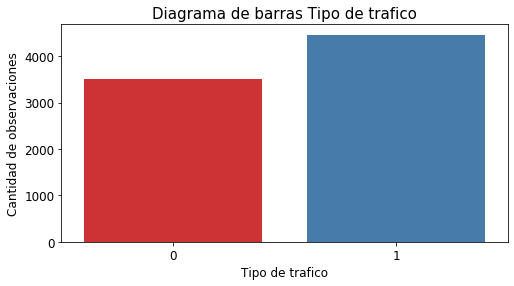

In [412]:

print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type_mine', data=data_final, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

In [414]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

Aleatoriedad


,index,#dp,#sp,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,first_dp,first_sp,min_d,p1_d,p1_ib,p1_ip,p2_ib,p3_d,p3_ib,second_dp,second_sp
1623,1912,2,2,0,1,0,1,56731,56731,0.0,6.17200,417.0,3.0,828.0,33.70525,2166.75,4444.0,4444.0
7627,3780,25,28,0,1,0,0,443,443,0.0,0.00000,32.0,1.0,70.5,82.45825,205.00,80.0,80.0
6101,24198,5,4,1,0,0,1,34560,0,0.0,0.00000,32.0,1.0,32.0,0.00000,40.00,1281.0,3333.0
6548,879,15,14,0,1,0,0,443,443,0.0,19.68575,93.0,3.0,128.0,135.16725,256.00,80.0,80.0
1452,1707,51,66,0,1,0,0,443,443,0.0,24.24550,116.0,3.0,160.0,180.21500,250.00,80.0,80.0


In [415]:
data_final.drop(['index'],axis =1, inplace=True)

In [416]:
data_final['Type_mine'] = data_final['Type_mine'].astype('int')

In [417]:
data_final.shape

(7966, 17)

### Modelo

In [418]:
X = data_final.drop('Type_mine', axis = 1)
y = data_final['Type_mine']

In [419]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [420]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


fit_time: 0.08 (+/- 0.01)
score_time: 0.03 (+/- 0.06)
test_accuracy: 1.00 (+/- 0.00)
test_precision_weighted: 1.00 (+/- 0.00)
test_recall_weighted: 1.00 (+/- 0.00)
test_f1_weighted: 1.00 (+/- 0.00)


In [421]:
K_fold = KFold(n_splits = 10)

In [422]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [423]:
scores

[0.998745294855709,
 0.998745294855709,
 0.9949811794228356,
 1.0,
 0.9924717691342535,
 0.9924717691342535,
 0.9962311557788944,
 0.9962311557788944,
 0.992462311557789,
 0.9962311557788944]

Matriz de confusión


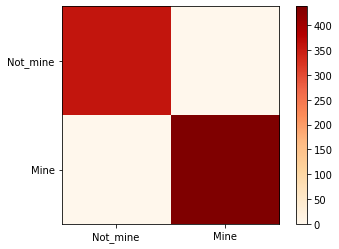

In [424]:
churm = matriz_confusion(y.iloc[resultados_test[3]], predicciones[3], plt.cm.OrRd)

In [425]:
pd.DataFrame(churm)

,0,1
0,359,0
1,0,438


In [426]:
metricas(y.iloc[resultados_test[7]], predicciones[7], churm)

Exactitud:  0.9962311557788944
Kappa:  0.9924148095443803
Metricas de los registros mineros
Precisión:  0.9976689976689976
Recall:  0.9953488372093023
Especificidad :  1.0
F1-score      :  0.9965075669383003
Metricas de los registros no mineros
Precisión:  0.9945504087193461
Recall:  0.9972677595628415
Especificidad :  1.0
F1-score      :  0.9959072305593452


### Prueba final

In [433]:
porcion_no_minera_conjuntoA.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [435]:
copy_porcion_minera_conjuntoB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [437]:
data_categoric = porcion_no_minera_conjuntoA[porcion_no_minera_conjuntoA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_TCP,First_Protocol_UDP,Type_not_mine
1512,1,0,1
4241,1,0,1


In [439]:
porcion_no_minera_conjuntoA = pd.concat([porcion_no_minera_conjuntoA,data_dummy], axis = 1).drop(['First_Protocol','Type_not_mine'], axis = 1)

In [440]:
dataB = dataB[~dataB.index.isin(porcion_minera_conjuntoB.index)]

In [449]:
prueba_final = pd.concat([porcion_no_minera_conjuntoA,dataB], axis = 0).replace({np.nan:0})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [453]:
X_p = prueba_final[bestFeature].drop('Type_mine',axis = 1)
y_p = prueba_final['Type_mine']

In [454]:
y_pred_proba = modelos[3].predict(X_p)

Matriz de confusión


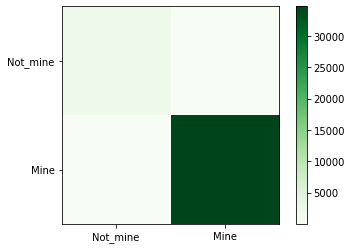

In [455]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [456]:
pd.DataFrame(churm)

,0,1
0,2184,19
1,86,34735


In [457]:
metricas(y_p, y_pred_proba, churm)

Exactitud:  0.9971640017286084
Kappa:  0.9750170191865478
Metricas de los registros mineros
Precisión:  0.9994533003395293
Recall:  0.9975302260130381
Especificidad :  0.9913753971856559
F1-score      :  0.9984908372260151
Metricas de los registros no mineros
Precisión:  0.9621145374449339
Recall:  0.9913753971856559
Especificidad :  0.9975302260130381
F1-score      :  0.9765258215962441


In [ ]:
y_pred_proba = model.predict_proba(X_test)

In [ ]:
lr_probs = y_pred_proba[:,1]

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]

In [ ]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

In [ ]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

In [ ]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Treeb: ROC AUC=%.3f' % (lr_auc))

In [ ]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

In [ ]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Holdaunt 70% pero debo hacer una validadci{on cruzada en este conjunto de entrenamiento (Puros), de este cruz validation saldra un modelo, y lo testeo con el 30%, con este porcentaje, le saco las metricas